In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import tables as tb
import numpy as np
from scipy.signal import find_peaks
from astropy.time import Time, TimeDelta
plt.rcParams['figure.figsize'] = [25, 10]

In [2]:
# List of files in directory /data01
os.listdir('/data01')

['output',
 'wf_runId_00115_configId_00000_2022-10-03T22_39_08.295757.h5',
 'wf_runId_00240_configId_00000_2022-10-10T08_21_49.133517.h5',
 'wf_runId_00249_configId_00000_2022-10-17T09_45_54.710368.h5',
 'wf_runId_00261_configId_00000_2022-10-24T08_30_50.143648.h5']

In [3]:
filePath_dl0 = "/data01/wf_runId_00249_configId_00000_2022-10-17T09_45_54.710368.h5"
dl1_path = os.path.join(os.path.dirname(os.getcwd()), 'dl1')
filePath_dl1 = os.path.join(dl1_path, 
                            os.path.basename(filePath_dl0).replace('.h5', '.dl1.h5')) 
print(filePath_dl0)
print(filePath_dl1)

/data01/wf_runId_00249_configId_00000_2022-10-17T09_45_54.710368.h5
/home/usergamma/workspace/dl1/wf_runId_00249_configId_00000_2022-10-17T09_45_54.710368.dl1.h5


In [4]:
with tb.open_file(filePath_dl0, mode='r') as h5_in:
    group = h5_in.get_node('/','waveforms')
    carray_original = group.__getitem__('wf_000000')
    print('Status:', carray_original._v_attrs.TimeSts)
    print('Year:', carray_original._v_attrs.Year)
    print('Month:', carray_original._v_attrs.Month)
    print('Day:', carray_original._v_attrs.Day)
    print('HH:', carray_original._v_attrs.HH)
    print('mm:', carray_original._v_attrs.mm)
    print('ss:', carray_original._v_attrs.ss)
    print('usec:', carray_original._v_attrs.usec)

Status: 1
Year: 122
Month: 9
Day: 17
HH: 0
mm: 0
ss: 82
usec: 710367


In [5]:
with tb.open_file(filePath_dl0, mode='r') as h5_in:
    group = h5_in.get_node('/','waveforms')
    carray_original = group.__getitem__('wf_000000')
    # Get the attributes from the original carray
    original_attrs = carray_original.attrs
    # original_attrs = carray_original._v_attrs
    print(type(original_attrs))
    print(original_attrs._f_list)
    # Copy the attributes to the new carray
    for name_attr in original_attrs._f_list():
        print(f'{name_attr} = {original_attrs[name_attr]}')
    print(original_attrs['VERSION'])

<class 'tables.attributeset.AttributeSet'>
<bound method AttributeSet._f_list of /waveforms/wf_000000._v_attrs (AttributeSet), 23 attributes:
   [CLASS := 'CARRAY',
    CurrentOffset := 630,
    Day := 17,
    Dec := 1,
    Eql := 1,
    HH := 0,
    Month := 9,
    PPSSliceNO := 255,
    SampleNo := 16384,
    TITLE := 'wf_0',
    TimeSts := 1,
    TriggerOffset := 1828,
    VERSION := '2.0',
    Year := 122,
    configID := 0,
    mm := 0,
    rp_id := 0,
    runid := 249,
    sessionID := 0,
    ss := 82,
    tend := 1665999954.7104988,
    tstart := 1665999954.7103677,
    usec := 710367]>
CurrentOffset = 630
Day = 17
Dec = 1
Eql = 1
HH = 0
Month = 9
PPSSliceNO = 255
SampleNo = 16384
TimeSts = 1
TriggerOffset = 1828
Year = 122
configID = 0
mm = 0
rp_id = 0
runid = 249
sessionID = 0
ss = 82
tend = 1665999954.7104988
tstart = 1665999954.7103677
usec = 710367
2.0


In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
def get_peak_lists(carray_i, deltav=20, thr_heur=80):
    """
    This function returns the list of peaks found in each waveform.
    ### Args
    * `source`: 
    * `deltav`: Define the width of range around peaks
    * `thr_heur`: threshold below which a peak is discarded, it is set as default to 80 and 
                  ithas been chosen with heuristics on data
    """
    # Extract array
    arr = carray_i[:,-1]
    # Compute moving average
    arrmov = moving_average(arr, 15)
    #
    arr3 = arr[:100]
    mmean1 = arr3.mean()
    mmean2 = mmean1 * 2 * 0.9 
    # Find peaks
    peaks, _ = find_peaks(arrmov, height=mmean2, width=15, distance=25)
    # Clone the peaks
    peaks2 = np.copy(peaks)
    # Filtering the peaks
    for v in peaks2:
        arrcalcMM = arrmov[v] - arrmov[v-deltav:v+deltav]
        #  
        ind = np.where(arrcalcMM[:] > thr_heur)
        # Remove peaks too small or peaks too close to the end of the wf
        if len(ind[0]) == 0 or v > 16000:
        # If  v > 16000:
            peaks = peaks[peaks != v]
    return peaks

attrubuto di che tipo stiamo parlando `wf_size` se c'è è dl1 altrimenti dl0

vedere bene cosa fanno tstart e tstop, esplorare il dato. potrebbe essere un dato assoluto. Aggiungi la lunghezza del dato buttato e moltiplicato 8 ns (unixtime.ms) 

per adesso copialo

se non viene calcolato log

aggiungere l'informazione di quale è il numero della wf rispetto al dl0 originale

-----

Rimplementare in dlo2dl1 implementa una routine che fa questa funzione

se timestatus (flag) per dire se è valido

tstart viene calcolato dallo unix time del redpId (della cpu) secondi,nanosecondi. Non considerare oltre i microsecondi

absolute time è il tempo di trigger della prima waveform

il trigt/delta_t ->

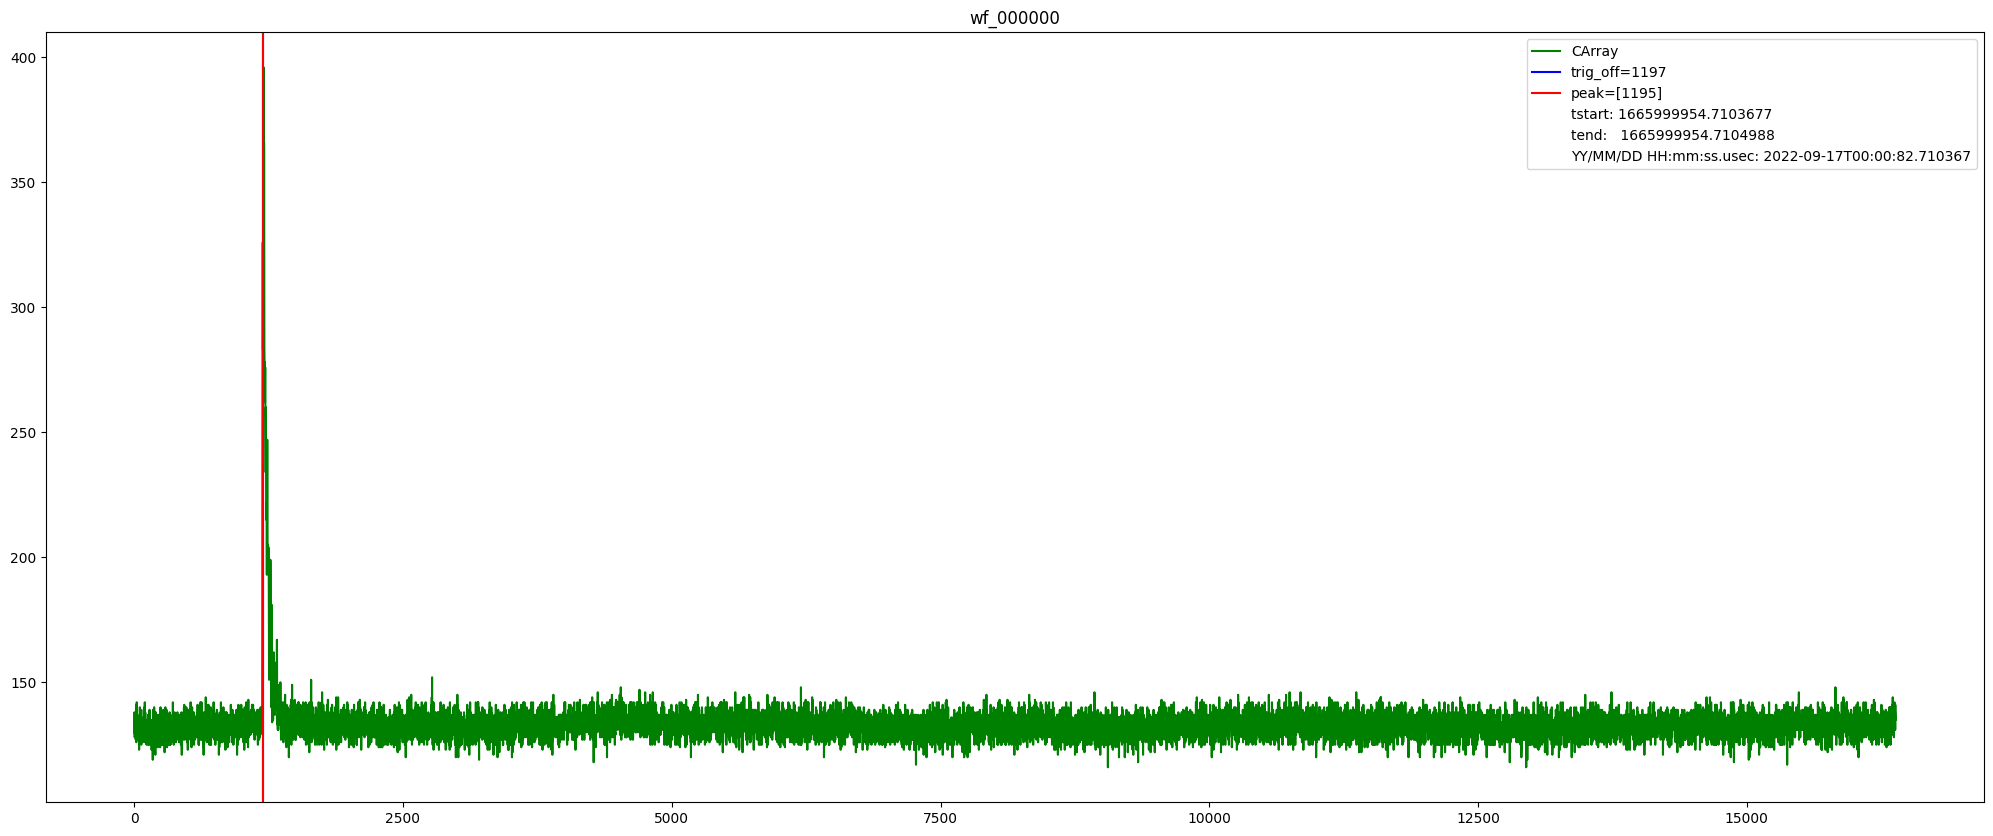

In [8]:
with tb.open_file(filePath_dl0, mode='r') as h5_out:
    group = h5_out.get_node('/','waveforms')
    for i, data in enumerate(group):
        # Extract array
        y = data[:,-1]
        lenwf = len(y)
        arr = y
        peak = get_peak_lists(data)
        plt.figure()
        plt.plot(arr, color='g', label="CArray")
        curr_off = data._v_attrs.CurrentOffset + 1
        trig_off = data._v_attrs.TriggerOffset
        tstart_off = (len(data)-curr_off)+trig_off if (curr_off > trig_off) else trig_off-curr_off
        plt.axvline(x=tstart_off, color='b', label=f'trig_off={tstart_off}') 
        plt.axvline(x=peak, color='r', label=f'peak={peak}') 
        # attrs
        plt.plot([], label=f"tstart: {data._v_attrs.tstart}", linestyle='')
        plt.plot([], label=f"tend:   {data._v_attrs.tend}", linestyle='')
        plt.plot([], label=f"YY/MM/DD HH:mm:ss.usec: "
                 f"{data._v_attrs.Year+1900}-{data._v_attrs.Month:02d}-{data._v_attrs.Day:02d}T"
                 f"{data._v_attrs.HH:02d}:{data._v_attrs.mm:02d}:{data._v_attrs.ss:02d}.{data._v_attrs.usec}", linestyle='')
        plt.title(data._v_name)
        plt.legend()
        plt.show(block=True)
        # Visualizzazione del grafico e attesa dell'input dell'utente
        F_esc = input("Premi Invio per continuare...")

        if F_esc == 'esc':
            break

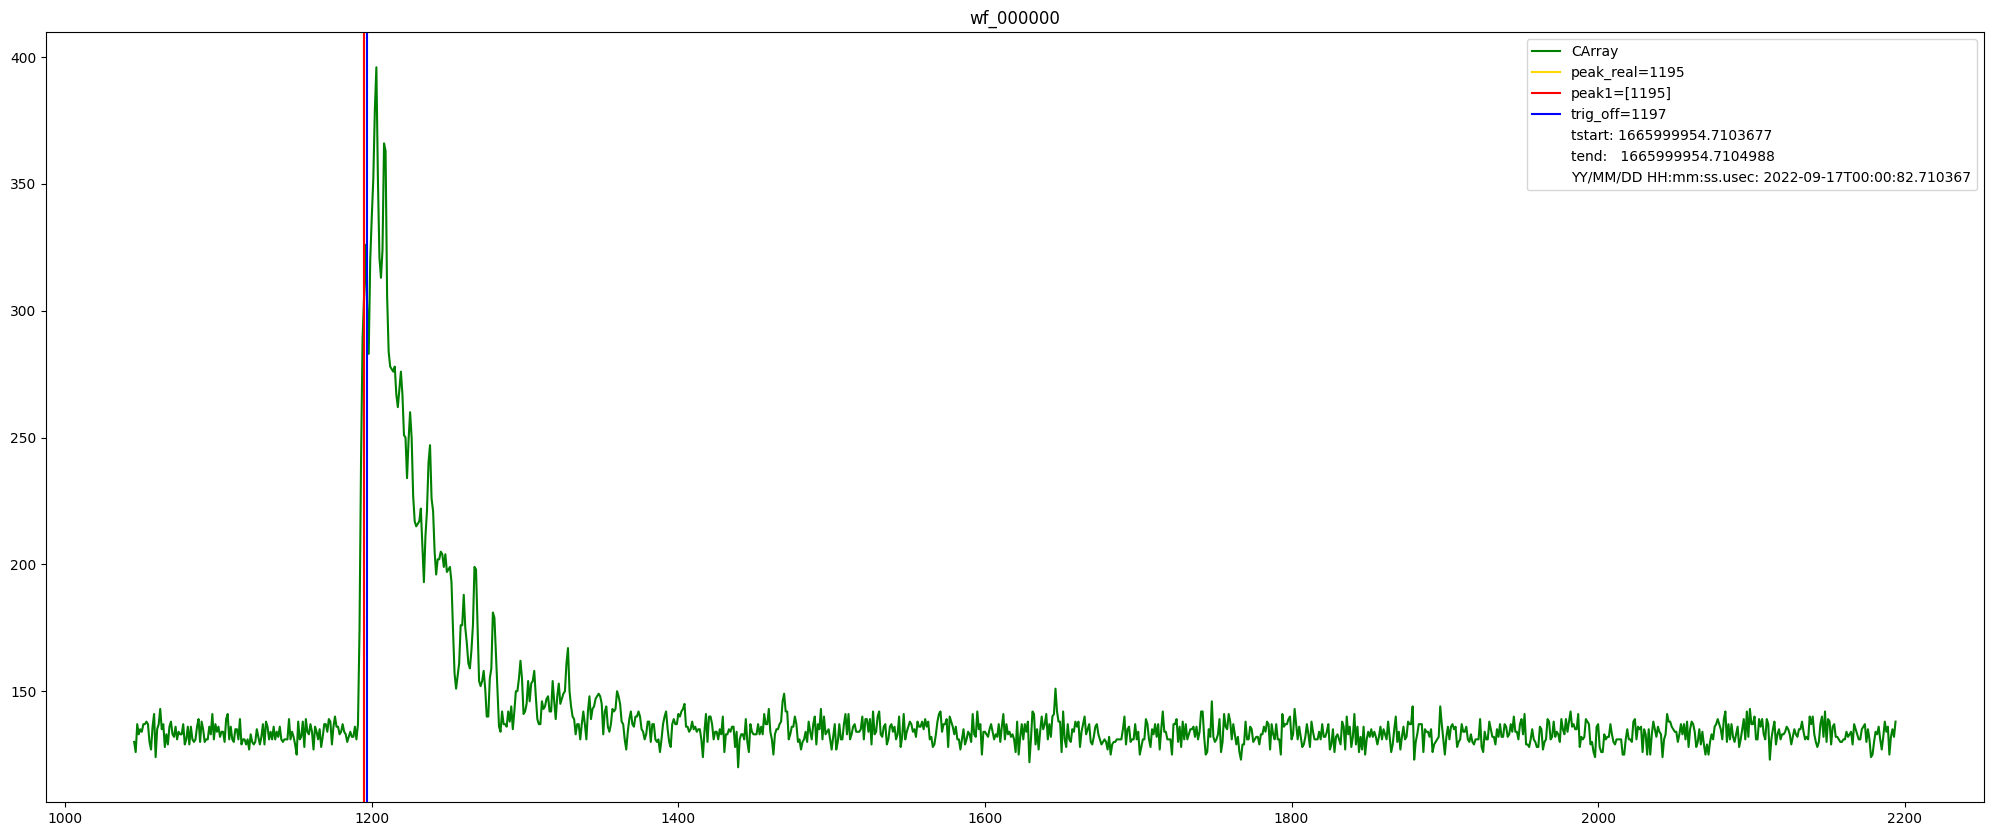

In [9]:
with tb.open_file(filePath_dl1, mode='r', title='dl1') as h5_out:
    group1 = h5_out.get_node('/','waveforms')
    for i, data in enumerate(group1):
        # Extract array
        y = data[:,-1]
        lenwf = len(y)
        arr = y
        peak1 = np.array(get_peak_lists(data))+data._v_attrs.wf_start
        peak = data._v_attrs.peak_pos
        curr_off = data._v_attrs.CurrentOffset + 1
        trig_off = data._v_attrs.TriggerOffset
        trig_off = (len(data)-curr_off)+trig_off if (curr_off > trig_off) else trig_off-curr_off
        plt.figure()
        plt.plot(np.arange(data._v_attrs.wf_start, 
                           data._v_attrs.wf_size + data._v_attrs.wf_start),
                arr, color='g', label="CArray")
        plt.axvline(x=peak, color='gold', label=f"peak_real={peak}") 
        plt.axvline(x=peak1, color='r', label=f"peak1={peak1}") 
        plt.axvline(x=trig_off, color='b', label=f"trig_off={trig_off}") 
        plt.title(data._v_attrs.original_wf)
        plt.plot([], label=f"tstart: {data._v_attrs.tstart}", linestyle='')
        plt.plot([], label=f"tend:   {data._v_attrs.tend}", linestyle='')
        plt.plot([], label=f"YY/MM/DD HH:mm:ss.usec: "
                 f"{data._v_attrs.Year+1900}-{data._v_attrs.Month:02d}-{data._v_attrs.Day:02d}T"
                 f"{data._v_attrs.HH:02d}:{data._v_attrs.mm:02d}:{data._v_attrs.ss:02d}.{data._v_attrs.usec}", linestyle='')
        plt.legend()
        plt.show(block=True)
        # Visualizzazione del grafico e attesa dell'input dell'utente
        F_esc = input("Premi Invio per continuare...")

        if F_esc == 'esc':
            break

In [10]:
# with tb.open_file(filePath_dl0, mode='r') as h5_in:
#     group = h5_in.get_node('/','waveforms')
#     with tb.open_file(filePath_dl1, mode='r', title='dl1') as h5_out:
#         group1 = h5_out.get_node('/','waveforms')
#         carray_original = group.__getitem__('wf_000000')
#         print(f'VERSION_original={carray_original._v_attrs.VERSION}')
#         print(f'VERSION_original={carray_original.attrs["VERSION"]}')
#         carray_new = group1.__getitem__('wf_000000')
#         print(f'VERSION_new={carray_new._v_attrs.VERSION}')
#         print(f'VERSION_new={carray_new.attrs["VERSION"]}')
        
#         dt_original = Time(f"{carray_original._v_attrs.Year+1900}-{carray_original._v_attrs.Month:02d}-{carray_original._v_attrs.Day:02d}T"
#                            f"{carray_original._v_attrs.HH:02d}:{carray_original._v_attrs.mm:02d}:{carray_original._v_attrs.ss:02d}.{carray_original._v_attrs.usec}", 
#                            format='isot', scale='utc', precision=6)
#         dt_new = Time(f"{carray_new._v_attrs.Year+1900}-{carray_new._v_attrs.Month:02d}-{carray_new._v_attrs.Day:02d}T"
#                         f"{carray_new._v_attrs.HH:02d}:{carray_new._v_attrs.mm:02d}:{carray_new._v_attrs.ss:02d}.{carray_new._v_attrs.usec}", 
#                         format='isot', scale='utc', precision=6)
#         print(dt_original-dt_new)

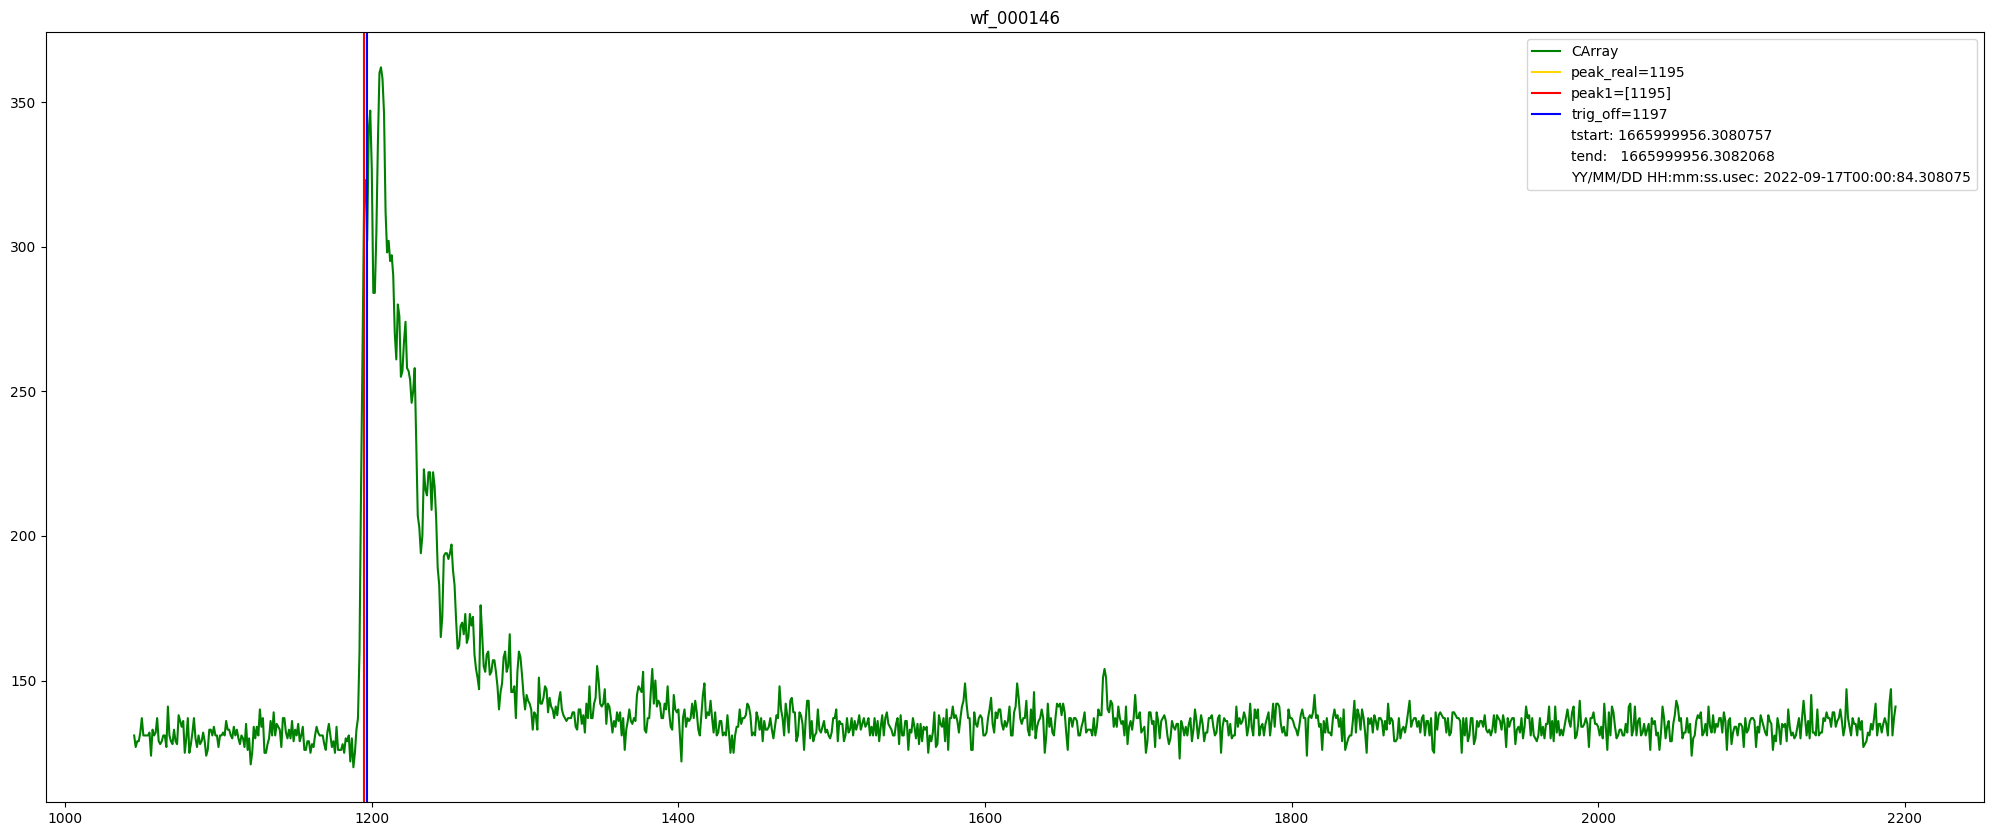

In [12]:
with tb.open_file(filePath_dl1, mode='r', title='dl1') as h5_out:
    group1 = h5_out.get_node('/','waveforms')
    data = group1.__getitem__('wf_000147')
    # Extract array
    y = data[:,-1]
    lenwf = len(y)
    arr = y
    peak1 = np.array(get_peak_lists(data))+data._v_attrs.wf_start
    peak = data._v_attrs.peak_pos
    curr_off = data._v_attrs.CurrentOffset + 1
    trig_off = data._v_attrs.TriggerOffset
    trig_off = (len(data)-curr_off)+trig_off if (curr_off > trig_off) else trig_off-curr_off
    plt.figure()
    plt.plot(np.arange(data._v_attrs.wf_start, 
                        data._v_attrs.wf_size + data._v_attrs.wf_start),
            arr, color='g', label="CArray")
    plt.axvline(x=peak, color='gold', label=f"peak_real={peak}") 
    plt.axvline(x=peak1, color='r', label=f"peak1={peak1}") 
    plt.axvline(x=trig_off, color='b', label=f"trig_off={trig_off}") 
    plt.title(data._v_attrs.original_wf)
    plt.plot([], label=f"tstart: {data._v_attrs.tstart}", linestyle='')
    plt.plot([], label=f"tend:   {data._v_attrs.tend}", linestyle='')
    plt.plot([], label=f"YY/MM/DD HH:mm:ss.usec: "
                f"{data._v_attrs.Year+1900}-{data._v_attrs.Month:02d}-{data._v_attrs.Day:02d}T"
                f"{data._v_attrs.HH:02d}:{data._v_attrs.mm:02d}:{data._v_attrs.ss:02d}.{data._v_attrs.usec}", linestyle='')
    plt.legend()
    plt.show(block=True)